In [1]:
import numpy as np
import scipy
from scipy.sparse import csc_matrix, bmat, load_npz, csr_matrix
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import implicit
from pathlib import Path
import re

## Load Data

In [2]:
s = load_npz("data/yt_s.npz")
a_train = load_npz("data/yt_a_train.npz")
a_test = load_npz("data/yt_a_test.npz")
a_val = load_npz("data/yt_a_val.npz")
n_groups = a_train.shape[1]
n_users = s.shape[0]

In [3]:
def prepare_train_data(alpha, s, a_train, a_val):
    c_train = bmat([[alpha*s, a_train], [a_train.transpose(), None]])
    c_val = bmat([[alpha*s, a_val], [a_val.transpose(), None]])
    #c_test = bmat([[alpha*s, a_test], [a_test.transpose(), None]])    
    return c_train.astype(np.float64), c_val.astype(np.float64)

## SVD

In [4]:
def svd_get_recs(i, model, train_labels, n_groups):
        u, sig, vt = model
        score = (u[i,:]@np.diag(sig)@vt)[-n_groups:]
        score = np.multiply(score, np.logical_not(train_labels))
        score_index = np.flip(np.argsort(score))
        return score_index

In [5]:
"vrati listu (za k = 1:n) precisiona i recalla na testu za jednog usera"
def evaluate_model_user(i, n, model, c_train, c_val, n_groups, model_type):
    "i = user za kojeg generiramo recommendatione"
    true_labels = c_val.getrow(i).toarray().flatten()[-n_groups:]
    train_labels = c_train.getrow(i).toarray().flatten()[-n_groups:]
    
    "tu se dodaju novi modeli"
    if model_type == "SVD":
        score_index = svd_get_recs(i, model, train_labels, n_groups)
    elif model_type == "ALS":
        score_index = als_get_recs(i, n, model, c_train, n_groups)
    elif model_type == "random_katz":
        score_index = rand_katz_get_recs(i, n, model, train_labels, n_groups)
    else:
        assert False
        
    positives = np.sum(true_labels)
    negatives = n_groups - positives
    user_i_stats = []
    for predictions in range(1, n+1):
        recommendations = score_index[:predictions]
        true_positives = np.sum(true_labels[recommendations] == 1)
        true_negatives = negatives - (predictions - true_positives)
        precision = true_positives/predictions
        sensitivity = true_positives/positives if positives != 0 else 1
        specificity = true_negatives/negatives
        user_i_stats.append((precision, sensitivity, specificity))
    return user_i_stats

In [6]:
def evaluate_model(model, c_train, c_val, n_users, n_groups, model_type):
    stats = []
    for i in tqdm(range(n_users)):
            if np.sum(c_val.getrow(i).toarray().flatten()[-n_groups:]) != 0:
                stats.append(evaluate_model_user(i, 50, model, c_train, c_val, n_groups, model_type))
    "stats mi je lista duljine broj usera, svaki element je lista duljine n koja sadrzi tupleove oblika (pr, se, sp)"
    pr_se_sp = []
    "pr_se_sp ce biti lista tupleova duljine n, tuple je oblika (mean_pr, mean_se, mean_sp) gdje je prosjek uzet po userima"
    for n in zip(*stats):
        pr_se_sp.append((np.mean([i for i,j,k in n]), np.mean([j for i,j,k in n]), np.mean([k for i,j,k in n])))
    "pss ce biti numpy array dimenzija n x 3, svaki stupac odgovara jednom od (pr, se, sp)"
    pss = np.array(pr_se_sp)
    return pss[:,0], pss[:,1], pss[:,2]

In [7]:
def get_score(precision, sensitivity, specificity):
    x=[(1-spec) for spec in specificity]
    area = np.trapz(y=sensitivity, x=x)
    return abs(area)

In [8]:
def svd_model(alpha, svd_rank, s, a_train, a_val, n_users, n_groups):
    c_train, c_val = prepare_train_data(alpha, s, a_train, a_val)
    model = svds(c_train, k = svd_rank)
    precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "SVD")
    score = get_score(precision, sensitivity, specificity)
    return {"alpha" : alpha, "svd_rank" : svd_rank, "score" : score, "precision" : precision, "sensitivity" : sensitivity, "specificity" : specificity}

In [9]:
def validate_svd_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups):
    validation_scores = []
    for alpha in alphas:
        for svd_rank in svd_ranks:
            validation_scores.append(svd_model(alpha, svd_rank, s, a_train, a_val, n_users, n_groups))
    return validation_scores

In [10]:
alphas = [3]
svd_ranks = [10]

In [ ]:
validation_scores_svd = validate_svd_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups)

In [ ]:
validation_scores_svd

In [ ]:
plt.plot(1 - validation_scores_svd[0]["specificity"], validation_scores_svd[0]["sensitivity"])

## EVALUACIJA GENERALNO

In [ ]:
"treba u evaluate_model_user za svaki model dodati granu u if-u u funkciji evaluate_model_user u kojoj se napravi score_index"
"score_index je lista/np.array koji sadrži indekse grupa sortirane po scoreu koji model daje, dakle sortirana lista grupa za recommendat"
"ideja je da se dotad sve sto ti treba za evaluirati model prenosi u varijabli model, a onda unutar tog ifa se pozove neka funkcija koja evaluira"
"za validaciju i kreiranje modela predlazem da se rade posebne funkcije za svaki jer nije bas zgodno napravit generalno, mogu biti po uzoru na ove"
#precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "SVD")
#score = get_score(precision, sensitivity, specificity)
"dole primjer za als - 3 modificirane funkcije i onda se samo pozove - nije bas savrseno al mislim da ce bit skroz ok za nasih par modela"

## ALS

In [11]:
def als_get_recs(i, n, model, c_train, n_groups):
    recs = model.recommend(i, user_items = csr_matrix(c_train), N = n, filter_already_liked_items = True, filter_items = [j for j in range(c_train.shape[0]-n_groups)])
    indices = [rec[0]-n_users for rec in recs]
    scores = [rec[1] for rec in recs]
    score = np.zeros(n_groups)
    score[indices] = scores
    score_index = np.flip(np.argsort(score))
    return score_index

In [16]:
def als_model(alpha, n_factors, s, a_train, a_val, n_users, n_groups):
    c_train, c_val = prepare_train_data(alpha, s, a_train, a_val)
    model = implicit.als.AlternatingLeastSquares(factors = n_factors, regularization = 2)
    model.fit(c_train)    
    precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "ALS")
    score = get_score(precision, sensitivity, specificity)
    return {"alpha" : alpha, "n_factors" : n_factors, "score" : score, "precision" : precision, "sensitivity" : sensitivity, "specificity" : specificity}

In [17]:
def validate_als_model(alphas, n_factors, s, a_train, a_val, n_users, n_groups):
    validation_scores = []
    for alpha in alphas:
        for nf in n_factors:
            validation_scores.append(als_model(alpha, nf, s, a_train, a_val, n_users, n_groups))
    return validation_scores

In [18]:
alphas = [3]
n_factors = [10]

In [19]:
validation_scores_als = validate_als_model(alphas, n_factors, s, a_train, a_val, n_users, n_groups)

  0%|          | 4/10000 [00:00<05:03, 32.95it/s]

100%|██████████| 10000/10000 [03:30<00:00, 47.40it/s]


In [20]:
validation_scores_als

[{'alpha': 3,
  'n_factors': 10,
  'score': 0.0008162966465115052,
  'precision': array([0.08418642, 0.06458782, 0.05374461, 0.04727909, 0.04197198,
         0.03829921, 0.03561807, 0.03353987, 0.0316092 , 0.02974138,
         0.02843358, 0.0270519 , 0.02601749, 0.02498653, 0.02407507,
         0.02322703, 0.02258969, 0.02193337, 0.02126106, 0.02066945,
         0.02010211, 0.01956799, 0.01902174, 0.01859397, 0.01817349,
         0.01776463, 0.01733617, 0.0169816 , 0.01659576, 0.01624012,
         0.01595088, 0.01565026, 0.01534744, 0.01509413, 0.01482836,
         0.01458483, 0.01431806, 0.01406534, 0.01382212, 0.01356748,
         0.01332856, 0.01311384, 0.01291537, 0.01267388, 0.01251497,
         0.01230732, 0.01213717, 0.0119657 , 0.01177648, 0.01158136]),
  'sensitivity': array([0.05744782, 0.08653701, 0.10492706, 0.12049146, 0.13174996,
         0.14234328, 0.15206338, 0.16182704, 0.16987926, 0.17639284,
         0.18458203, 0.19104648, 0.19716164, 0.20268339, 0.20813678,
      

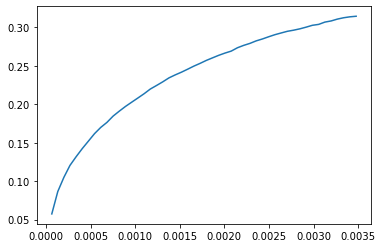

In [21]:
plt.plot(1 - validation_scores_als[0]["specificity"], validation_scores_als[0]["sensitivity"])

## Katz

In [ ]:
def katz(t, beta, k):
    katz = beta*t
    a = beta*t
    for i in range(k-1):
        a = beta*a@t
        katz = katz + a
    return katz

In [ ]:
def katz_2(t, beta, k):
    t = t.astype(np.float64)
    u, s, vt = svds(t, k=3)
    s = np.diag(s)
    
    vtu = vt@u
    svtu = s@vtu
    
    katz = beta*s
    #a = beta*svtu
    small_matrix = beta * s @ vtu
    for i in range(k-1):
        small_matrix = beta * small_matrix @ s
        katz = katz + small_matrix
        small_matrix = small_matrix @ vtu
    katz = u @ katz @ vt
    return katz

## Random Katz

In [ ]:
def rand_katz_get_recs(i, n, model, train_labels, n_groups):
    recs = model[i]
    score = np.multiply(recs, np.logical_not(train_labels))
    score_index = np.flip(np.argsort(score))
    return score_index

In [ ]:
import struct

def read_results_from_bin(bin_file_path, n_groups):
    # format is uint32, uint32, double
    fmt = "IId"
    record_len = struct.calcsize(fmt)
    unpack = struct.Struct(fmt).unpack_from
    result = {}
    with open(bin_file_path, "rb") as file:
        data = file.read(record_len)
        while data:
            user, group, score = unpack(data)
            if user not in result:
                result[user] = np.zeros(n_groups)
            result[user][group-1] = score
            data = file.read(record_len)
    return result

In [ ]:
def random_katz_model(file, s, a_train, a_val, n_users, n_groups):
    model = read_results_from_bin(str(file), n_groups)   #model je izracunat vec u nekom c++ kodu, ovdje samo učitaom file
    c_train, c_val = prepare_train_data(1, s, a_train, a_val)
    precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "random_katz")
    score = get_score(precision, sensitivity, specificity)
    path_len, iterations = tuple(int(s) for s in re.findall(r'\d+', str(file)))       # cisto da imamo podatke o duljini puta i broju iteracija u ovom modelu
    return {"iterations": iterations, "path_len": path_len, "score": score, "precision": precision, "sensitivity": sensitivity, "specificity": specificity}

In [ ]:
def validate_random_katz_model(s, a_train, a_val, n_users, n_groups):
    validation_scores = []
    for file in Path("data/random_katz/results/").iterdir():
        # ime filea je recs_{duljina_puta}_{broj_iteracija}
        validation_scores.append(random_katz_model(file, s, a_train, a_val, n_users, n_groups))
    return validation_scores

In [ ]:
%%time

rand_katz_validation_scores = validate_random_katz_model(s, a_train, a_val, n_users, n_groups)

In [ ]:
for val_score in rand_katz_validation_scores:
    plt.plot(1 - val_score["specificity"], val_score["sensitivity"])

In [ ]:
rand_katz_validation_scores[0]